In [37]:
import pandas as pd
import numpy as np
import math
from sklearn.cluster import,AgglomerativeClustering,DBSCAN,SpectralClustering
import matplotlib.pyplot as plt
from sklearn.metrics import calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
import umap.umap_ as umap
from sklearn.metrics.pairwise import cosine_distances
import kmapper as km
from sklearn import preprocessing
import gower as gw
import seaborn as sb

# load test set distance matrix and dataset

gower_distance_matrix = np.load("data/testset_distance_matrix.npy")
dataset_communities = pd.read_excel("results/testset_predicted_community.xlsx")
communities = dataset_communities['predicted_community']

dataset_communities_features = dataset_communities.loc[:, ~dataset_communities.columns.isin(['PATIENT_ID','CUORE_10yCV_riskscore'])]

continue_features=  ["Age","Height","Weight","BMI","Systolic blood pressure","Diastolic blood pressure",'Heart rate',
                  'Abdominal circumference','Pelvis circumference',  'Oxygen saturation', "Years as a smoker",
                    "Leukocytes","Erythrocytes","Haemoglobin","Haematocrit","MCV","MCH","MCHC","RDW","Platelets","MPV",
               'Neutrophils %', 'Lymphocytes %', 'Monocytes %', 'Eosinophils %', 'Basophils #',
                  'Neutrophils #', 'Lymphocytes #', 'Monocytes #', 'Eosinophils #', 'Basophils %', 'Blood sugar', 
                  'Uric acid', 'GGT', 'Total bilirubin', 'hsTnI', 'Triglycerides','Total cholesterol', 'HDL cholesterol',
                  'LDL cholesterol', 'CRP', 'hs-CRP', 'HbA1c-IFCC', 'HbA1c-DCCT']


## Looking for the epsilon value for DBSCAN, using the elbow rule

Looking for epsilong value


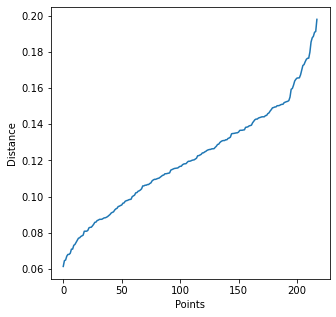

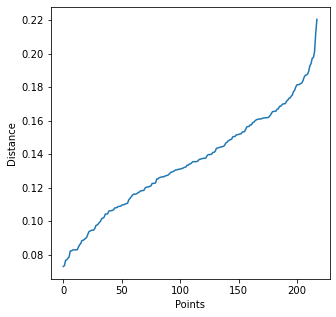

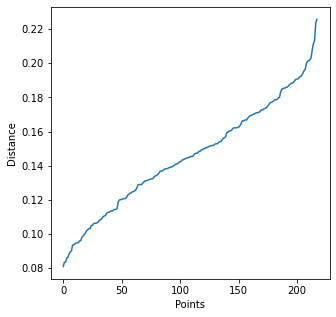

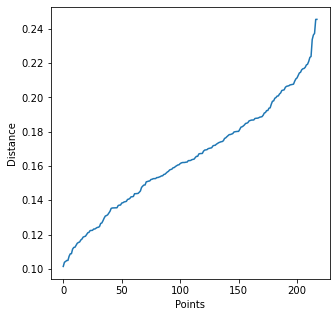

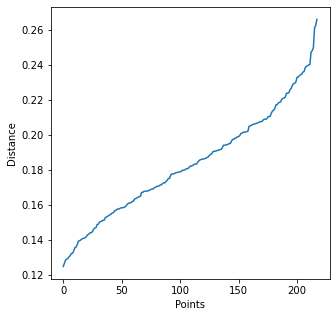

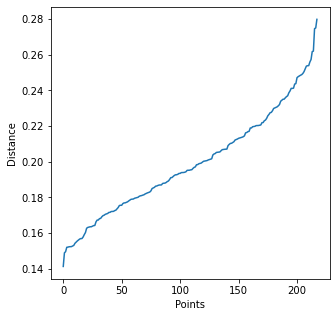

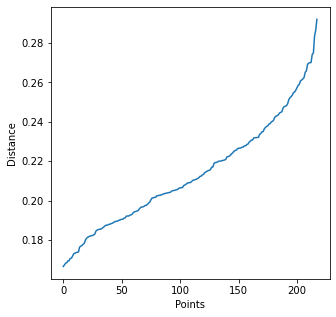

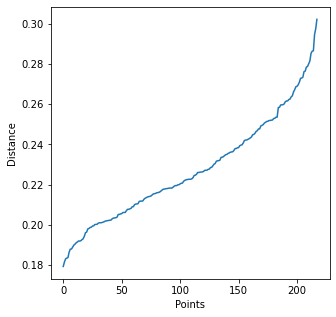

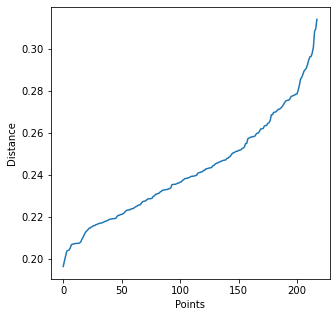

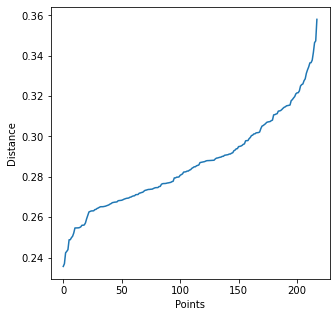

Looking for epsilong value - after UMAP projection


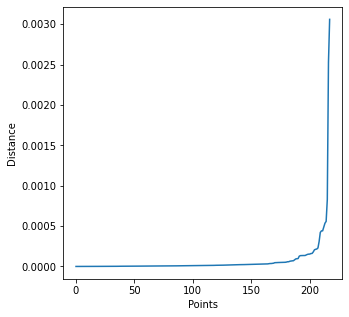

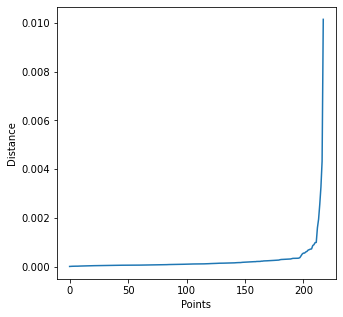

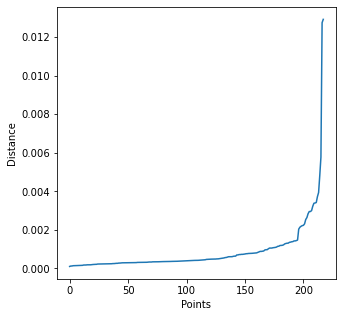

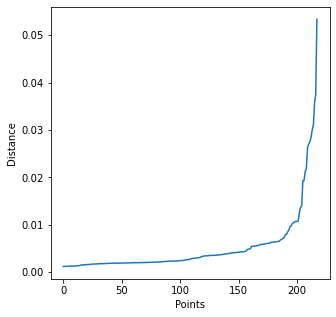

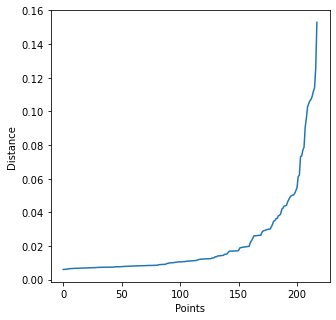

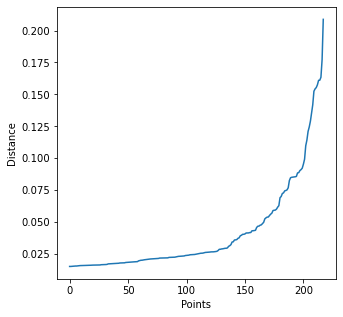

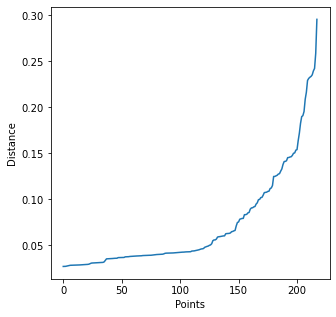

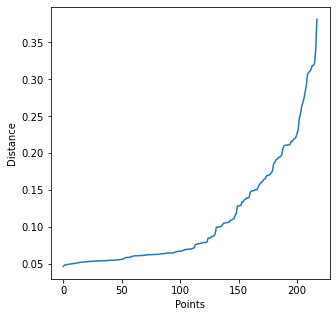

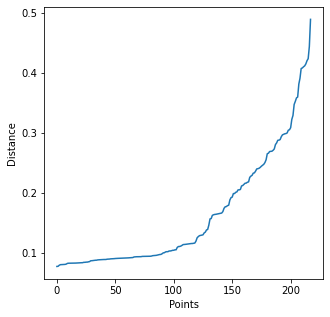

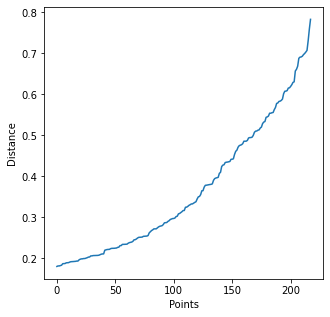

In [32]:
# DBSCAN
print("Looking for epsilong value")
for n in [2,5,10,25,50,75,100,125,150,200]:
    nearest_neighbors = NearestNeighbors(n_neighbors=n+1,metric="precomputed")
    neighbors = nearest_neighbors.fit(gower_distance_matrix)
    distances, indices = neighbors.kneighbors(gower_distance_matrix)
    distances_sorted = np.sort(distances[:,n], axis=0)

    fig = plt.figure(figsize=(5, 5))
    plt.plot(distances_sorted)
    plt.xlabel("Points")
    plt.ylabel("Distance")
    plt.show()

# DBSCAN after UMAP
print("Looking for epsilong value - after UMAP projection")
mapper = km.KeplerMapper()  
projection = mapper.project(gower_distance_matrix, projection= umap.UMAP(n_components=2, random_state=203, n_neighbors= 50, min_dist=0.9),distance_matrix = None, scaler = None)
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(projection)
distance_matrix = cosine_distances(X_scaled,X_scaled)

for n in [2,5,10,25,50,75,100,125,150,200]:
    nearest_neighbors = NearestNeighbors(n_neighbors=n+1,metric="precomputed")
    neighbors = nearest_neighbors.fit(distance_matrix)
    distances, indices = neighbors.kneighbors(distance_matrix)
    distances_sorted = np.sort(distances[:,n], axis=0)

    fig = plt.figure(figsize=(5, 5))
    plt.plot(distances_sorted)
    plt.xlabel("Points")
    plt.ylabel("Distance")
    plt.show()

## Define clustering methods

In [40]:

after_UMAP_dbscan_min_sample_2 = DBSCAN(metric="precomputed",min_samples=2,eps=0.2)
dbscan_min_sample_2 = DBSCAN(metric="precomputed",min_samples=450,eps=0.5)

agglomerative_avg_Nclusters_as_Ncommunities = AgglomerativeClustering(n_clusters = 5,affinity = "precomputed",linkage="complete")

spectral_clustering_km = SpectralClustering(n_clusters=5,assign_labels='kmeans', random_state=203, affinity="precomputed")


In [39]:
def compare_pipeline_with_cluster(dataset_communities,distance_matrix,cluster_method,projection_lens,rnd,communities):
       
    """
    Funcion that compare the partition obtained with pheTDA with the partition obtained with a clustering algorithm.
    INPUT:
        - dataset_with_communities   (pandas DataFrame) patients testset with an additional column, indicating the predicted subroup.
        - distance_matrix:      (numpy ndarray) patients distance matrix
        - cluster_method: (sklearn clustering method) custering method to compare
        - projection_lens: (sklearn or umap-learn object) the projection lens to use
        - rnd: (int) seed for reproducible output
        - communities: (pandas Series) Series containing the predicted community for each patients
    OUTPUT:
        - clusters: (numpy ndarray) predicted labels according to the clustering algorithm
    """
        
    if projection_lens!="":
        mapper = km.KeplerMapper()  
        projection = mapper.project(distance_matrix, projection= projection_lens,distance_matrix = None, scaler = None)
        min_max_scaler = preprocessing.MinMaxScaler()
        X_scaled = min_max_scaler.fit_transform(projection)
        distance_matrix = cosine_distances(X_scaled,X_scaled)
        clusters = cluster_method.fit_predict(distance_matrix)
        print(clusters)
        print("First project with " + str(str(umap.UMAP(n_components=2, random_state=rnd, n_neighbors= 50, min_dist=0.9))) + " ,then cluster with " +str(cluster_method) )
    else:
        clusters = cluster_method.fit_predict(distance_matrix)
        print(clusters)
        print("Cluster with " + str(cluster_method))
        
    silhouette_communities = silhouette_score(distance_matrix,communities,metric="precomputed")
    silhouette_to_compare = silhouette_score(distance_matrix,clusters,metric="precomputed")
    
    ch_communities = calinski_harabasz_score(dataset_communities,communities)
    ch_to_compare = calinski_harabasz_score(dataset_communities,clusters)
    
    n_clusters = len(set(clusters))
    print("Number of clusters: " + str(n_clusters))
    n_communities = len(set(communities))
    print("Number of communities: " + str(n_communities))
    
    print("Silhouette score TDA: " + str(silhouette_communities) + " - - - Silhouette score cluster method: "+ str(silhouette_to_compare) )
    print("calinski_harabasz score TDA: " + str(ch_communities) + " - - - calinski_harabasz score cluster method: "+ str(ch_to_compare) )

    print("\n")
    
    return clusters

In [42]:
communities = dataset_communities_features['predicted_community']

#compare_pipeline_with_cluster(dataset_communities_features.loc[:, ~dataset_communities_features.columns.isin(['predicted_community'])],gower_distance_matrix,after_UMAP_dbscan_min_sample_2,"T",203,communities)
print("agglo")
compare_pipeline_with_cluster(dataset_communities_features.loc[:, ~dataset_communities_features.columns.isin(['predicted_community'])],gower_distance_matrix,agglomerative_avg_Nclusters_as_Ncommunities,"T",203,communities)
print("\n")
print("spectr")
compare_pipeline_with_cluster(dataset_communities_features.loc[:, ~dataset_communities_features.columns.isin(['predicted_community'])],gower_distance_matrix,spectral_clustering_km,"T",203,communities)
        






      

agglo
[1 3 1 1 1 3 0 1 0 0 1 1 3 1 0 1 2 2 3 1 4 1 3 2 2 0 1 4 1 2 2 4 2 0 1 0 2
 0 1 2 0 2 2 1 3 3 0 0 2 3 1 2 1 1 2 3 2 3 3 1 2 3 1 1 2 0 3 2 1 1 0 2 3 2
 0 0 2 3 4 3 1 1 0 1 0 1 1 0 2 2 3 0 0 3 3 1 3 0 0 0 4 1 4 1 2 0 2 1 0 0 0
 1 1 3 1 1 1 2 2 2 1 1 3 0 0 0 2 2 1 2 2 1 4 1 1 2 2 0 2 3 3 1 2 4 2 2 1 1
 1 2 0 0 2 1 1 0 1 0 3 0 2 4 3 0 1 2 2 1 0 4 1 2 2 0 1 3 3 3 1 2 2 4 4 4 0
 3 3 2 3 3 3 0 2 2 0 4 3 0 2 3 0 0 2 2 2 3 2 4 2 3 3 2 4 1 4 1 2 0]
First project with UMAP(min_dist=0.9, n_neighbors=50, random_state=203) ,then cluster with AgglomerativeClustering(affinity='precomputed', linkage='complete',
                        n_clusters=5)
Number of clusters: 5
Number of communities: 5
Silhouette score TDA: -0.080876164 - - - Silhouette score cluster method: 0.2674742
calinski_harabasz score TDA: 6.142829987118142 - - - calinski_harabasz score cluster method: 14.118915504182846




spectr
[4 0 1 2 4 3 3 2 4 3 0 0 0 2 0 4 2 1 2 0 2 2 3 4 4 1 4 2 4 0 3 4 3 4 0 1 3
 2 2 0 2 3 3 3 0 0 2 2 2 

array([4, 0, 1, 2, 4, 3, 3, 2, 4, 3, 0, 0, 0, 2, 0, 4, 2, 1, 2, 0, 2, 2,
       3, 4, 4, 1, 4, 2, 4, 0, 3, 4, 3, 4, 0, 1, 3, 2, 2, 0, 2, 3, 3, 3,
       0, 0, 2, 2, 2, 0, 0, 3, 1, 2, 1, 2, 1, 1, 3, 3, 0, 0, 1, 4, 3, 0,
       2, 1, 4, 2, 2, 4, 2, 4, 0, 3, 2, 2, 3, 0, 2, 2, 0, 0, 2, 2, 4, 3,
       2, 1, 3, 1, 4, 2, 2, 3, 1, 0, 3, 2, 2, 1, 4, 0, 1, 1, 0, 2, 2, 1,
       3, 3, 0, 1, 3, 1, 4, 0, 1, 3, 4, 3, 1, 0, 2, 0, 0, 1, 2, 2, 2, 3,
       0, 1, 1, 2, 2, 2, 2, 4, 2, 1, 2, 1, 3, 2, 3, 2, 2, 0, 2, 2, 1, 1,
       4, 1, 1, 0, 2, 0, 3, 3, 3, 4, 2, 0, 0, 1, 0, 3, 1, 1, 1, 3, 2, 0,
       3, 1, 1, 1, 4, 2, 1, 2, 4, 1, 4, 1, 4, 0, 0, 4, 3, 2, 3, 3, 2, 2,
       1, 3, 4, 3, 0, 0, 0, 1, 4, 0, 2, 2, 4, 1, 2, 0, 0, 4, 3, 2])